# Imports

In [34]:
# base
import numpy as np
import networkx as nx
import pkg_resources
from sklearn.impute import SimpleImputer
from pandas_plink import read_plink
import allel
from scipy.spatial import distance

# viz
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs

# feems
from feems.utils import prepare_graph_inputs
from feems import SpatialGraph, Viz
from feems.cross_validation import run_cv
from feems import setup_graph

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

# Functions

In [3]:
def fit_and_plot_simulation(ax, scenario, sampling_design, rep,
                            factr=1e8, lamb_grid=np.geomspace(1e-6, 1e2, 20)[::-1],
                            alpha_fact=1.0, true_weights=None, draw_cbar=False, 
                            obs_node_size=1.0, obs_node_linewidth=.2, cbar_ticklabelsize=12, 
                            cbar_width = "50%", cbar_height = "10%", cbar_loc="center", 
                            cbar_bbox_to_anchor=(0.0, -.8, 1, 1), title_loc="left", 
                            title_pad="-10", title_fontsize=0, abs_max=1):
    print("running: ", scenario, sampling_design, rep)
    
    # read simulation outputs
    genotypes = np.loadtxt("../output/simulations/{}_{}_rep{}/genotypes.txt".format(scenario, sampling_design, rep))
    edges = np.loadtxt("../output/simulations/{}_{}_rep{}/edges.txt".format(scenario, sampling_design, rep))
    grid = np.loadtxt("../output/simulations/{}_{}_rep{}/grid.txt".format(scenario, sampling_design, rep))
    coord = np.loadtxt("../output/simulations/{}_{}_rep{}/coord.txt".format(scenario, sampling_design, rep))

    # filter to common variants
    n = genotypes.shape[0]
    mu = genotypes.sum(axis=0) / (2.0 * n)
    common_var_idx = (mu >= .05) & (mu <= .95)
    genotypes = genotypes[:, common_var_idx]
    print("genotype dimension: ", genotypes.shape)
    
    # setup spatial graph
    sp_graph = SpatialGraph(genotypes, coord, grid, edges, scale_snps=True)
    n_folds = sp_graph.n_observed_nodes
    print("n_folds: ", n_folds)
    print("")
    
    # if the true weights are not provided run cv
    if true_weights is None:  
        # run cv
        cv_err = run_cv(
            sp_graph, lamb_grid, 
            n_folds=n_folds, 
            factr=factr, 
            outer_verbose=False, 
            inner_verbose=False, 
            alpha_fact=alpha_fact
        )
    
        # re-fit solution with min cv err
        mean_cv_err = np.mean(cv_err, axis=0)
        lamb_cv = float(lamb_grid[np.argmin(mean_cv_err)])
        sp_graph.fit(float(lamb_cv), verbose=False)
    else:
        # dummy run
        sp_graph.fit(100.0, verbose=False)

    # visualize
    v = Viz(ax, sp_graph, projection=None)
    if true_weights is not None:
        v.norm_log_weights = np.log10(true_weights) - np.mean(np.log10(true_weights))
        v.obs_node_size = 0.0
    else:
        v.obs_node_size = obs_node_size
    v.abs_max = abs_max
    v.obs_node_linewidth = obs_node_linewidth
    v.cbar_ticklabelsize = cbar_ticklabelsize
    v.cbar_width = cbar_width
    v.cbar_height = cbar_height
    v.cbar_loc = cbar_loc
    v.cbar_bbox_to_anchor = cbar_bbox_to_anchor
    if draw_cbar == True:
        v.draw_edge_colorbar()
    v.draw_edges(use_weights=True)
    v.draw_obs_nodes(use_ids=False)
    
    
def get_true_weights(anisotropy_scaler, barrier_w, corridor_w,
                     n_rows=8, n_columns=12, barrier_startpt=2.5, 
                     barrier_endpt=8.5):
    graph, coord, grid, edges = setup_graph(n_rows=n_rows,
                                            n_columns=n_columns,
                                            barrier_startpt=barrier_startpt,
                                            barrier_endpt=barrier_endpt,
                                            anisotropy_scaler=anisotropy_scaler,
                                            barrier_w=barrier_w,
                                            corridor_w=corridor_w)
    W = nx.adjacency_matrix(graph, weight="w")
    idx = nx.adjacency_matrix(graph).nonzero()
    idx = list(np.column_stack(idx))
    true_weights = np.array([])
    for i in range(len(idx)):
        true_weights = np.append(true_weights, W[idx[i][0],idx[i][1]])
    
    return(true_weights)

# Visualize

running:  weakhetiso nonmissing 0
genotype dimension:  (766, 7177)
n_folds:  96

running:  weakhetiso missingatrandom 0
genotype dimension:  (138, 9030)
n_folds:  18

CPU times: user 3min 12s, sys: 6.55 s, total: 3min 19s
Wall time: 3min 19s


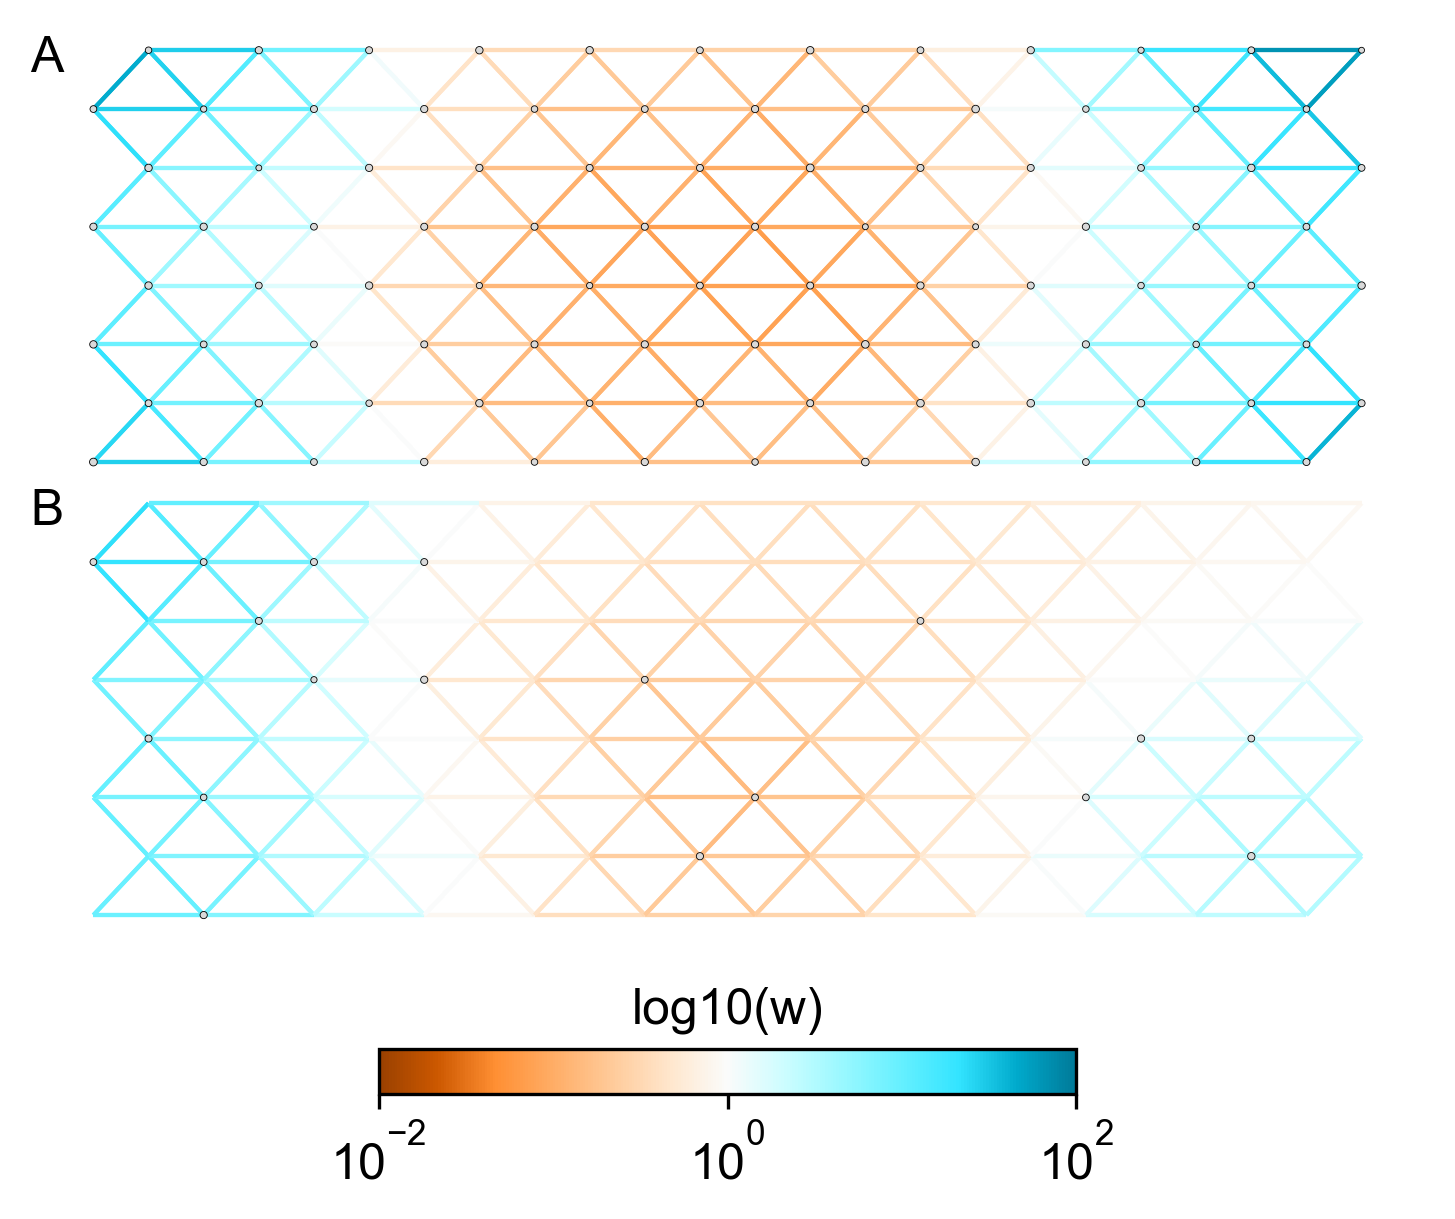

In [4]:
%%time
title_loc = "left"
title_pad = "-10"
title_fontsize = 12

# setup figure
fig = plt.figure(dpi=300)
spec = gridspec.GridSpec(
    ncols=1, nrows=2, figure=fig, wspace=0.0, hspace=0.0
)

rep = 0

# sub-figures
ax_00 = fig.add_subplot(spec[0, 0])
ax_00.set_title("A", loc=title_loc, pad=title_pad, 
                fontdict={"fontsize": title_fontsize})
fit_and_plot_simulation(
    ax_00, "weakhetiso", "nonmissing", rep, abs_max = .15
)

ax_10 = fig.add_subplot(spec[1, 0])
ax_10.set_title("B", loc=title_loc, pad=title_pad, 
                fontdict={"fontsize": title_fontsize})
fit_and_plot_simulation(
    ax_10, "weakhetiso", "missingatrandom", rep, abs_max = .15, draw_cbar = True
)

In [5]:
fig.set_size_inches(3, 4)
fig.savefig(
    "../output/figures/supp-figure-21-weak-coal-sim.pdf", dpi=300, bbox_inches="tight", pad_inches=.1
)

# Plot Fst

In [18]:
def comp_fst_mat(genotypes, obs_ids):
    """Computes an Fst distnace matrix from a sample
    genotype matrix and set of sub-population ids
    """
    n_snps = genotypes.shape[1]
    n_demes = np.max(obs_ids) + 1
    acs = np.empty((n_demes, n_snps, 2))
    
    # compute allele counts
    for i in range(n_demes):
        Gi = genotypes[obs_ids == i, :]
        acs[i, :, 0] = np.sum(Gi, axis=0)
        acs[i, :, 1] = (2 * Gi.shape[0]) - np.sum(Gi, axis=0) 
    
    # compute Fst matrix
    Fst = np.empty((n_demes, n_demes))
    for i in range(n_demes):
        for j in range(n_demes):
            num, den = allel.patterson_fst(acs[i, :, :].astype(np.int32), 
                                           acs[j, :, :].astype(np.int32))
            Fst[i, j] = np.sum(num) / np.sum(den)
    Fst[Fst<0.0] = 0.0
    return(Fst)

In [33]:
scenario = "weakhetiso"
sampling_design = "nonmissing"
rep = 0
genotypes = np.loadtxt("../output/simulations/{}_{}_rep{}/genotypes.txt".format(scenario, sampling_design, rep))
edges = np.loadtxt("../output/simulations/{}_{}_rep{}/edges.txt".format(scenario, sampling_design, rep))
grid = np.loadtxt("../output/simulations/{}_{}_rep{}/grid.txt".format(scenario, sampling_design, rep))
coord = np.loadtxt("../output/simulations/{}_{}_rep{}/coord.txt".format(scenario, sampling_design, rep))
n = genotypes.shape[0]
mu = genotypes.sum(axis=0) / (2*n)
common_var_idx = (mu>=.05) & (mu <= .95)
mu_c = mu[common_var_idx]
genotypes_weak = genotypes[:, common_var_idx]
sp_graph_weak = SpatialGraph(genotypes, coord, grid, edges, scale_snps=True)

scenario = "hetiso"
sampling_design = "nonmissing"
rep = 0
genotypes = np.loadtxt("../output/simulations/{}_{}_rep{}/genotypes.txt".format(scenario, sampling_design, rep))
edges = np.loadtxt("../output/simulations/{}_{}_rep{}/edges.txt".format(scenario, sampling_design, rep))
grid = np.loadtxt("../output/simulations/{}_{}_rep{}/grid.txt".format(scenario, sampling_design, rep))
coord = np.loadtxt("../output/simulations/{}_{}_rep{}/coord.txt".format(scenario, sampling_design, rep))
n = genotypes.shape[0]
mu = genotypes.sum(axis=0) / (2*n)
common_var_idx = (mu>=.05) & (mu <= .95)
mu_c = mu[common_var_idx]
genotypes_strong = genotypes[:, common_var_idx]
sp_graph_strong = SpatialGraph(genotypes_strong, coord, grid, edges, scale_snps=True)

Text(0, 0.5, 'Fst')

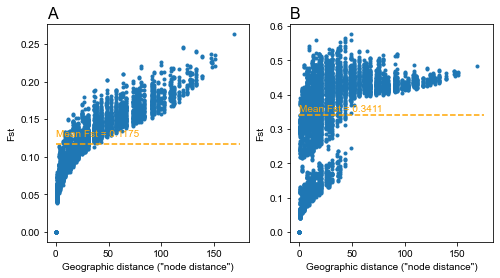

In [36]:
fig = plt.figure(figsize=(8, 4))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

D_geo = distance.squareform(distance.pdist(grid, "sqeuclidean"))

ax_00 = fig.add_subplot(spec[0, 0])
Fst = comp_fst_mat(genotypes_weak, sp_graph_weak.assned_node_idx)
ax_00.scatter(np.tril(D_geo, -1), np.tril(Fst, -1), marker=".")
ax_00.set_title("A", loc="left", fontdict={"fontsize": 16})

ax_00.hlines(np.mean(Fst), 0, 175, linestyles="dashed", color="orange")
ax_00.annotate("Mean Fst = {:.4f}".format(np.mean(Fst)), xy=(0, np.mean(Fst) + .01), color = "orange")
ax_00.set_xlabel('Geographic distance ("node distance")')
ax_00.set_ylabel("Fst")

ax_01 = fig.add_subplot(spec[0, 1])
Fst = comp_fst_mat(genotypes_strong, sp_graph_strong.assned_node_idx)
ax_01.scatter(np.tril(D_geo, -1), np.tril(Fst, -1), marker=".")
ax_01.set_title("B", loc="left", fontdict={"fontsize": 16})

ax_01.hlines(np.mean(Fst), 0, 175, linestyles="dashed", color="orange")
ax_01.annotate("Mean Fst = {:.4f}".format(np.mean(Fst)), xy=(0, np.mean(Fst) + .01), color = "orange")
ax_01.set_xlabel('Geographic distance ("node distance")')
ax_01.set_ylabel("Fst")

In [37]:
fig.savefig(
    "../output/figures/supp-figure-20-weak-coal-sim-fst.pdf", dpi=300, bbox_inches="tight", pad_inches=.1
)